# Some rank-based analysis

&copy; **Johannes Ruf** (comments welcome under j.ruf@lse.ac.uk, March 2023)

Here are three projects, the second one is the most open-ended one.

1. Plot the capital distribution curves for different times in the past. The capital distribution curve plots the capitalization of a company (here understood as unique `permno`) against its rank (on a log-log scale). See [here](https://commons.wikimedia.org/wiki/File:U.S._Stock_market_capital_distribution_curves_1929-2009.pdf) for an example.

2. How many different companies had the largest capitalization at some point of time since the start of CRSP? 
What's the relative market capitalization of largest company at the end of December 2022 (Apple)? Is there any indication that more capital is allocated in the largest stock(s) relative to the past?  How long does a company with the largest capitalization usually keep its place?  What happens to those companies afterwards?

3. One can measure the diversity of markets via functions that are large when all companies have the same capitalization and small when one company is very large compared to the others. Examples for such measures of diversity are 

\begin{align*}
G(\mu) &= 1 - \sum_i \mu_i^2;\\
G(\mu) &=  - \sum_i \mu_i \log(\mu_i);\\
G(\mu) &= \left(\sum_i \mu_i^p\right)^{1/p},
\end{align*}

where $\mu$ is the vector of market weights. How do these measures evolve over time?

## Some exemplary answers

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import wrds
WRDS_LOGIN = 'xxx'    # update to your login info on CRSP

DATAPATH = '~/Desktop/YOUR_FOLDER_NAME/'

### Capital distribution curves

In [11]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly.h5') as store:
    mktcaps = store['df']['mthprevcap']

Just adding a row at the beginning:

In [12]:
mktcaps = pd.concat([pd.DataFrame(np.nan, index=[pd.to_datetime('1925-12-30')], columns=mktcaps.columns), mktcaps])

In [13]:
mktcaps = mktcaps.shift(-1).iloc[:-1]

In [14]:
mktweights = mktcaps.div(mktcaps.sum(axis=1), axis=0)  

In [15]:
years = [1926, 1950, 1975, 2000, 2022]

In [16]:
df_tmp = mktweights[mktweights.index.year.isin(years) & (mktweights.index.month == 6)].T

In [17]:
plot_weights = pd.DataFrame()
for col in df_tmp:
    x = df_tmp[col].sort_values(ascending=False).reset_index(drop=True)
    plot_weights[col] = x
    
plot_weights = plot_weights.dropna(how='all')
plot_weights.index += 1
plot_weights.columns = plot_weights.columns.astype('str')

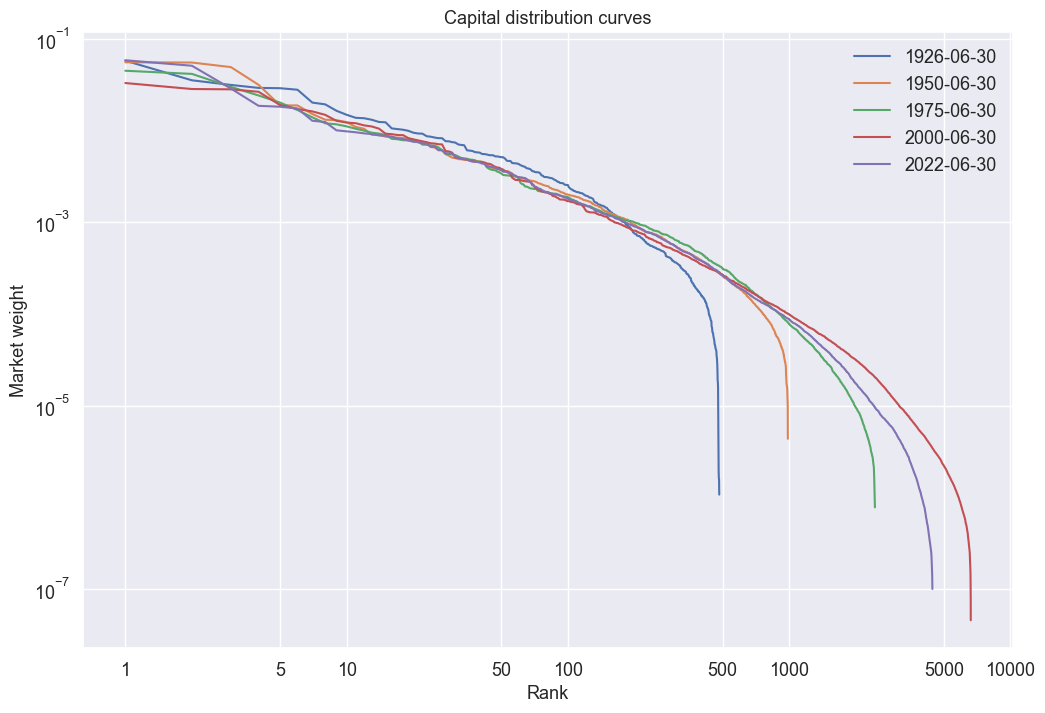

In [18]:
fontsize = 13
ax = plot_weights.plot(loglog=True, figsize=(12, 8), fontsize=fontsize)

ax.set_title('Capital distribution curves')
ax.set_ylabel('Market weight')
ax.set_xlabel('Rank')

xlabels = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_xticks(xlabels), ax.set_xticklabels(xlabels)

ylabels = [1/10, 1/1000, 1/100000, 1/10000000]
ax.set_yticks(ylabels)
     
ax.legend(frameon=False, prop={'size': fontsize})
for item in [ax.title, ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(fontsize);  

#### An alternative plot

We could also normalize the x-axis to 100%. Here the largest company starts at 1% (to avoid logarithmic effects), the smallest company ends at 100%. Then the plot doesn't look as stable.

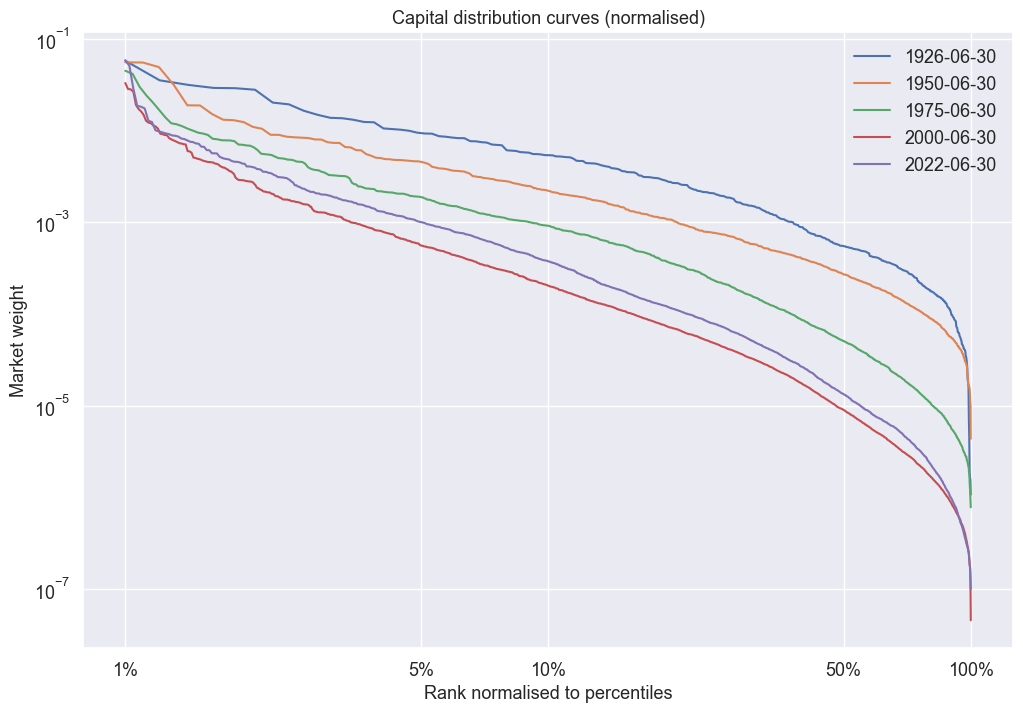

In [19]:
fontsize = 13

_, ax = plt.subplots(figsize=(12, 8))
plt.yscale('log')
plt.xscale('log')

n_of_stocks = plot_weights.count()
for col in plot_weights:
    x = np.linspace(1, 100, n_of_stocks[col])
    ax.plot(x, plot_weights[col].iloc[: n_of_stocks[col]], label=col)
    
ax.set_title('Capital distribution curves (normalised)')
ax.set_ylabel('Market weight')
ax.set_xlabel('Rank normalised to percentiles')
    
xlabels = [1, 5, 10, 50, 100]
ax.set_xticks(xlabels), ax.set_xticklabels([str(l) + '%' for l in xlabels])

ylabels = [1/10, 1/1000, 1/100000, 1/10000000]
ax.set_yticks(ylabels)

    
plt.legend(frameon=False, prop={'size': fontsize});
for item in [ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fontsize);  

### Maximum market weights:

Let us now work with daily data to make sure we capture each stock that might have been a market leader sometimes.

In [20]:
%%time

with pd.HDFStore(DATAPATH + 'CRSP_daily.h5') as store:
    mktcaps = store['df']['dlyprevcap']

CPU times: user 57.1 s, sys: 54.8 s, total: 1min 51s
Wall time: 2min 24s


In [21]:
%%time

mktweights = mktcaps.div(mktcaps.sum(axis=1), axis=0).iloc[1:]

CPU times: user 28.8 s, sys: 25.2 s, total: 54 s
Wall time: 47.3 s


In [22]:
wmax = mktweights.max(axis=1)

In [23]:
%%time

leaders = mktweights.idxmax(axis=1)

CPU times: user 28.6 s, sys: 15 s, total: 43.6 s
Wall time: 49.8 s


In [24]:
print('There are {} different PERMNOs that were market leaders at some point of time.'.format(len(leaders.unique())))

There are 11 different PERMNOs that were market leaders at some point of time.


In [25]:
dates_change_leader = leaders.index[leaders != leaders.shift(1)][1:]

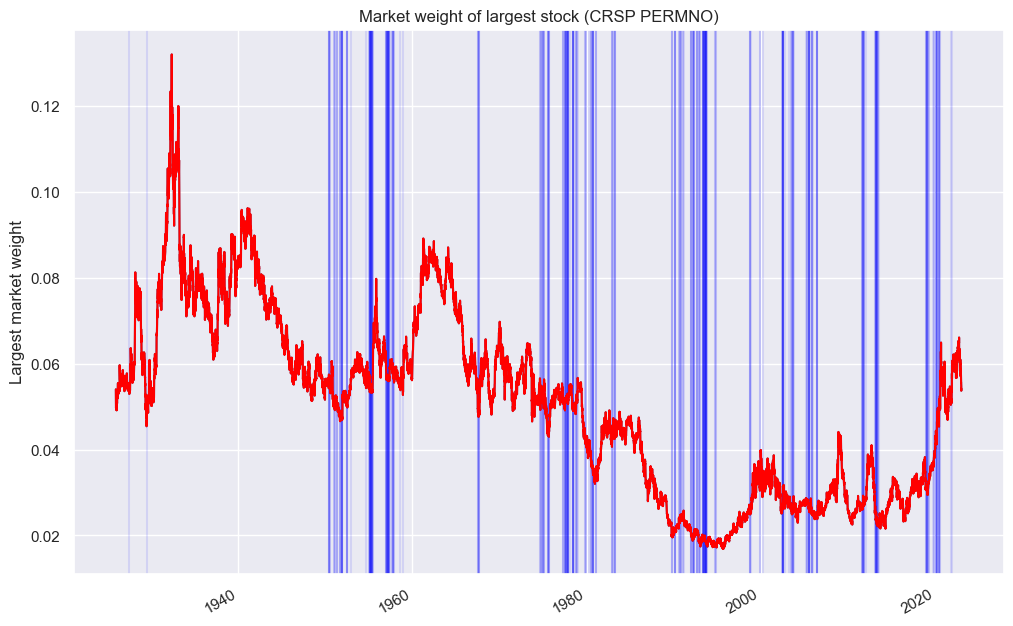

In [26]:
ax = wmax.plot(figsize=(12,8))

for d in dates_change_leader:
    ax.axvline(d, alpha = 0.1, color='blue')
    
wmax.plot(ax=ax, color='red')

ax.set_title('Market weight of largest stock (CRSP PERMNO)')
ax.set_ylabel('Largest market weight')
ax.set_xlabel('');

In the previous plot, the blue vertical lines highlight times when the leader changes.

Let's now check which companies stay how long as leaders:

In [27]:
%%time

db = wrds.Connection(wrds_username=WRDS_LOGIN)

stocknames = pd.DataFrame()
for p in leaders.unique():
    tmp = db.raw_sql("""SELECT permno, issuernm, secinfostartdt, secinfoenddt FROM crsp.StkSecurityInfoHist 
                    WHERE permno = {}
                    """.format(p), date_cols=['secinfostartdt', 'secinfoenddt'])    
    stocknames = pd.concat([stocknames, tmp])

db.close()

Loading library list...
Done
CPU times: user 73.7 ms, sys: 46.2 ms, total: 120 ms
Wall time: 3.9 s


In [28]:
leaders = leaders.to_frame()
leaders.columns = ['permno']

In [29]:
%%time

def find_issuernm(row):
    return stocknames[stocknames['permno'].eq(row['permno']) & stocknames['secinfostartdt'].le(row.name) & 
                   stocknames['secinfoenddt'].ge(row.name)]['issuernm'].iloc[0]

leaders['issuernm'] = leaders.apply(find_issuernm, axis=1)

CPU times: user 17.9 s, sys: 90.1 ms, total: 18 s
Wall time: 18.1 s


We can now display all 11 leaders (as of Feb 2022), and check how many trading days they were market leaders:

In [30]:
leaders.groupby(['permno', 'issuernm']).size().sort_index()

permno   issuernm                        
10107.0  MICROSOFT CORP                        781
10401.0  A T & T CORP                           26
         AMERICAN TELEPHONE & TELEG CO       10772
11703.0  DU PONT E I DE NEMOURS & CO            11
11850.0  EXXON CORP                            659
         EXXON MOBIL CORP                     1656
         STANDARD OIL CO N J                   151
12060.0  GENERAL ELECTRIC CO                  2477
12079.0  GENERAL MOTORS CORP                  1627
12490.0  INTERNATIONAL BUSINESS MACHS COR     4890
13901.0  PHILIP MORRIS COS INC                  34
14593.0  APPLE INC                            2448
55976.0  WAL MART STORES INC                     3
84788.0  AMAZON COM INC                         13
dtype: int64

Let's now plot how these 11 one-time leaders evolve over time.

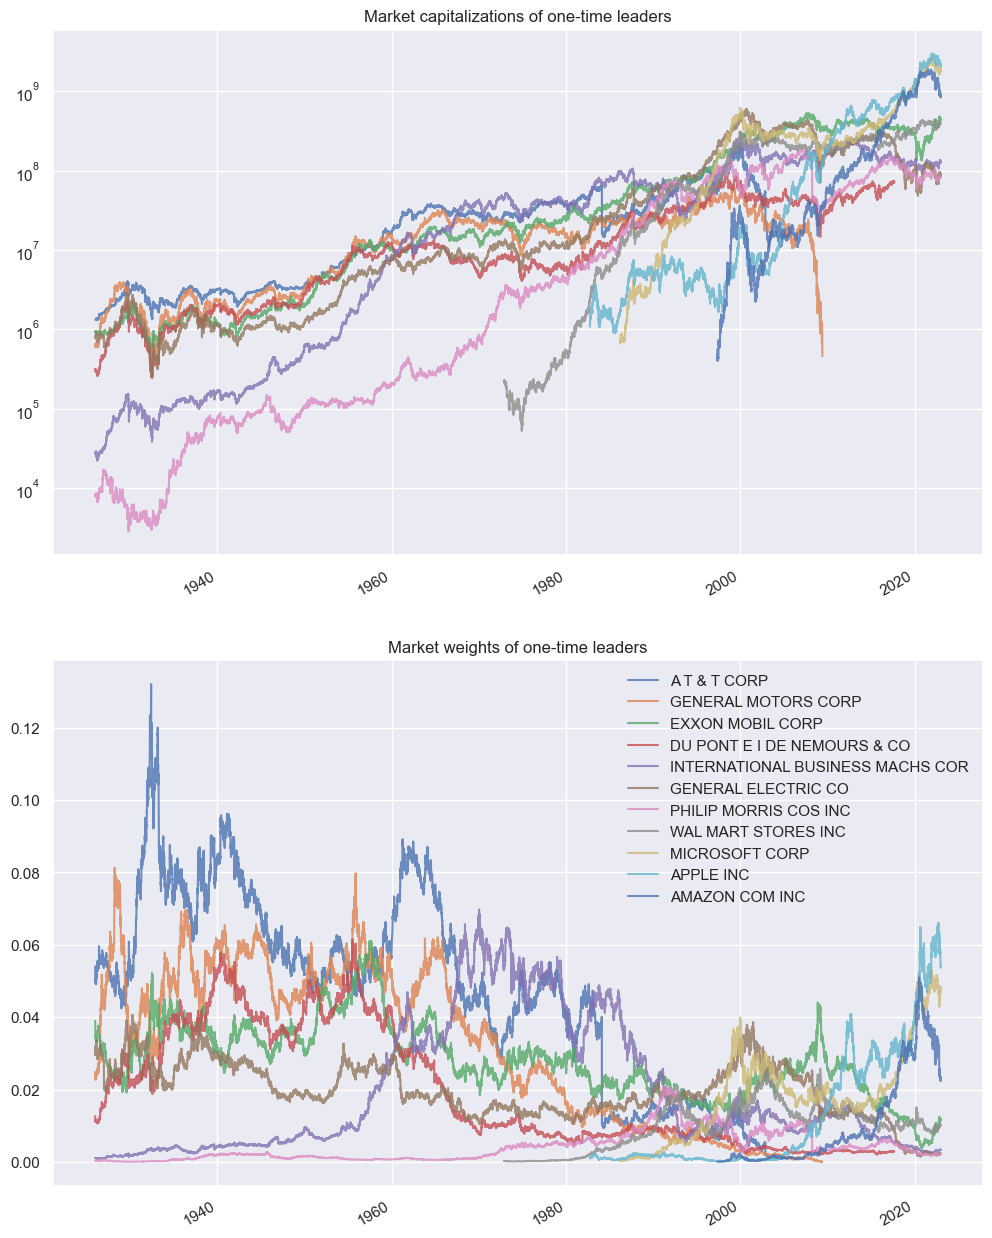

In [31]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,17))

mktcaps[leaders['permno'].unique()].plot(alpha=0.8, logy=True, legend=None, ax=ax1)
mktweights[leaders['permno'].unique()].plot(alpha=0.8, ax=ax2)

tmp = leaders.groupby(['permno'])['issuernm'].last()[leaders['permno'].unique()]
ax2.legend(tmp, frameon=False);

ax1.set_title('Market capitalizations of one-time leaders')
ax2.set_title('Market weights of one-time leaders')

for ax in (ax1, ax2):
    ax.set_xlabel('')

We now study the dynamics of the leaders' market capitalzations and market weights before the first day they took the lead and after the last day they were leading:

In [32]:
df_caps_before = pd.DataFrame(index=np.arange(0, len(mktcaps)))
df_weights_before = pd.DataFrame(index=np.arange(0, len(mktcaps)))

for p in leaders['permno'].unique():
    df_caps_before[p] = mktcaps.loc[: leaders[leaders['permno'].eq(p)].index.min(), p][::-1].reset_index(drop=True)
    df_weights_before[p] = mktweights.loc[: leaders[leaders['permno'].eq(p)].index.min(), p][::-1].reset_index(
        drop=True)

df_caps_before = df_caps_before.dropna(how='all')
df_weights_before = df_weights_before.dropna(how='all')

df_caps_before.index = -df_caps_before.index
df_weights_before.index = -df_weights_before.index

df_caps_before = df_caps_before.iloc[:15_000]
df_weights_before = df_weights_before.iloc[:15_000]

df_caps_before = df_caps_before.div(df_caps_before.loc[0])
df_weights_before = df_weights_before.div(df_weights_before.loc[0])

In [33]:
df_caps_after = pd.DataFrame(index=np.arange(0, len(mktcaps)))
df_weights_after = pd.DataFrame(index=np.arange(0, len(mktcaps)))

for p in leaders.permno.unique():
    df_caps_after[p] = mktcaps.loc[leaders[leaders['permno'].eq(p)].index.max():, p].reset_index(drop=True)
    df_weights_after[p] = mktweights.loc[leaders[leaders['permno'].eq(p)].index.max():, p].reset_index(drop=True)

df_caps_after = df_caps_after.dropna(how='all')
df_weights_after = df_weights_after.dropna(how='all')

df_caps_after = df_caps_after.iloc[:15_000]
df_weights_after = df_weights_after.iloc[:15_000]

df_caps_after = df_caps_after.div(df_caps_after.loc[0])
df_weights_after = df_weights_after.div(df_weights_after.loc[0])

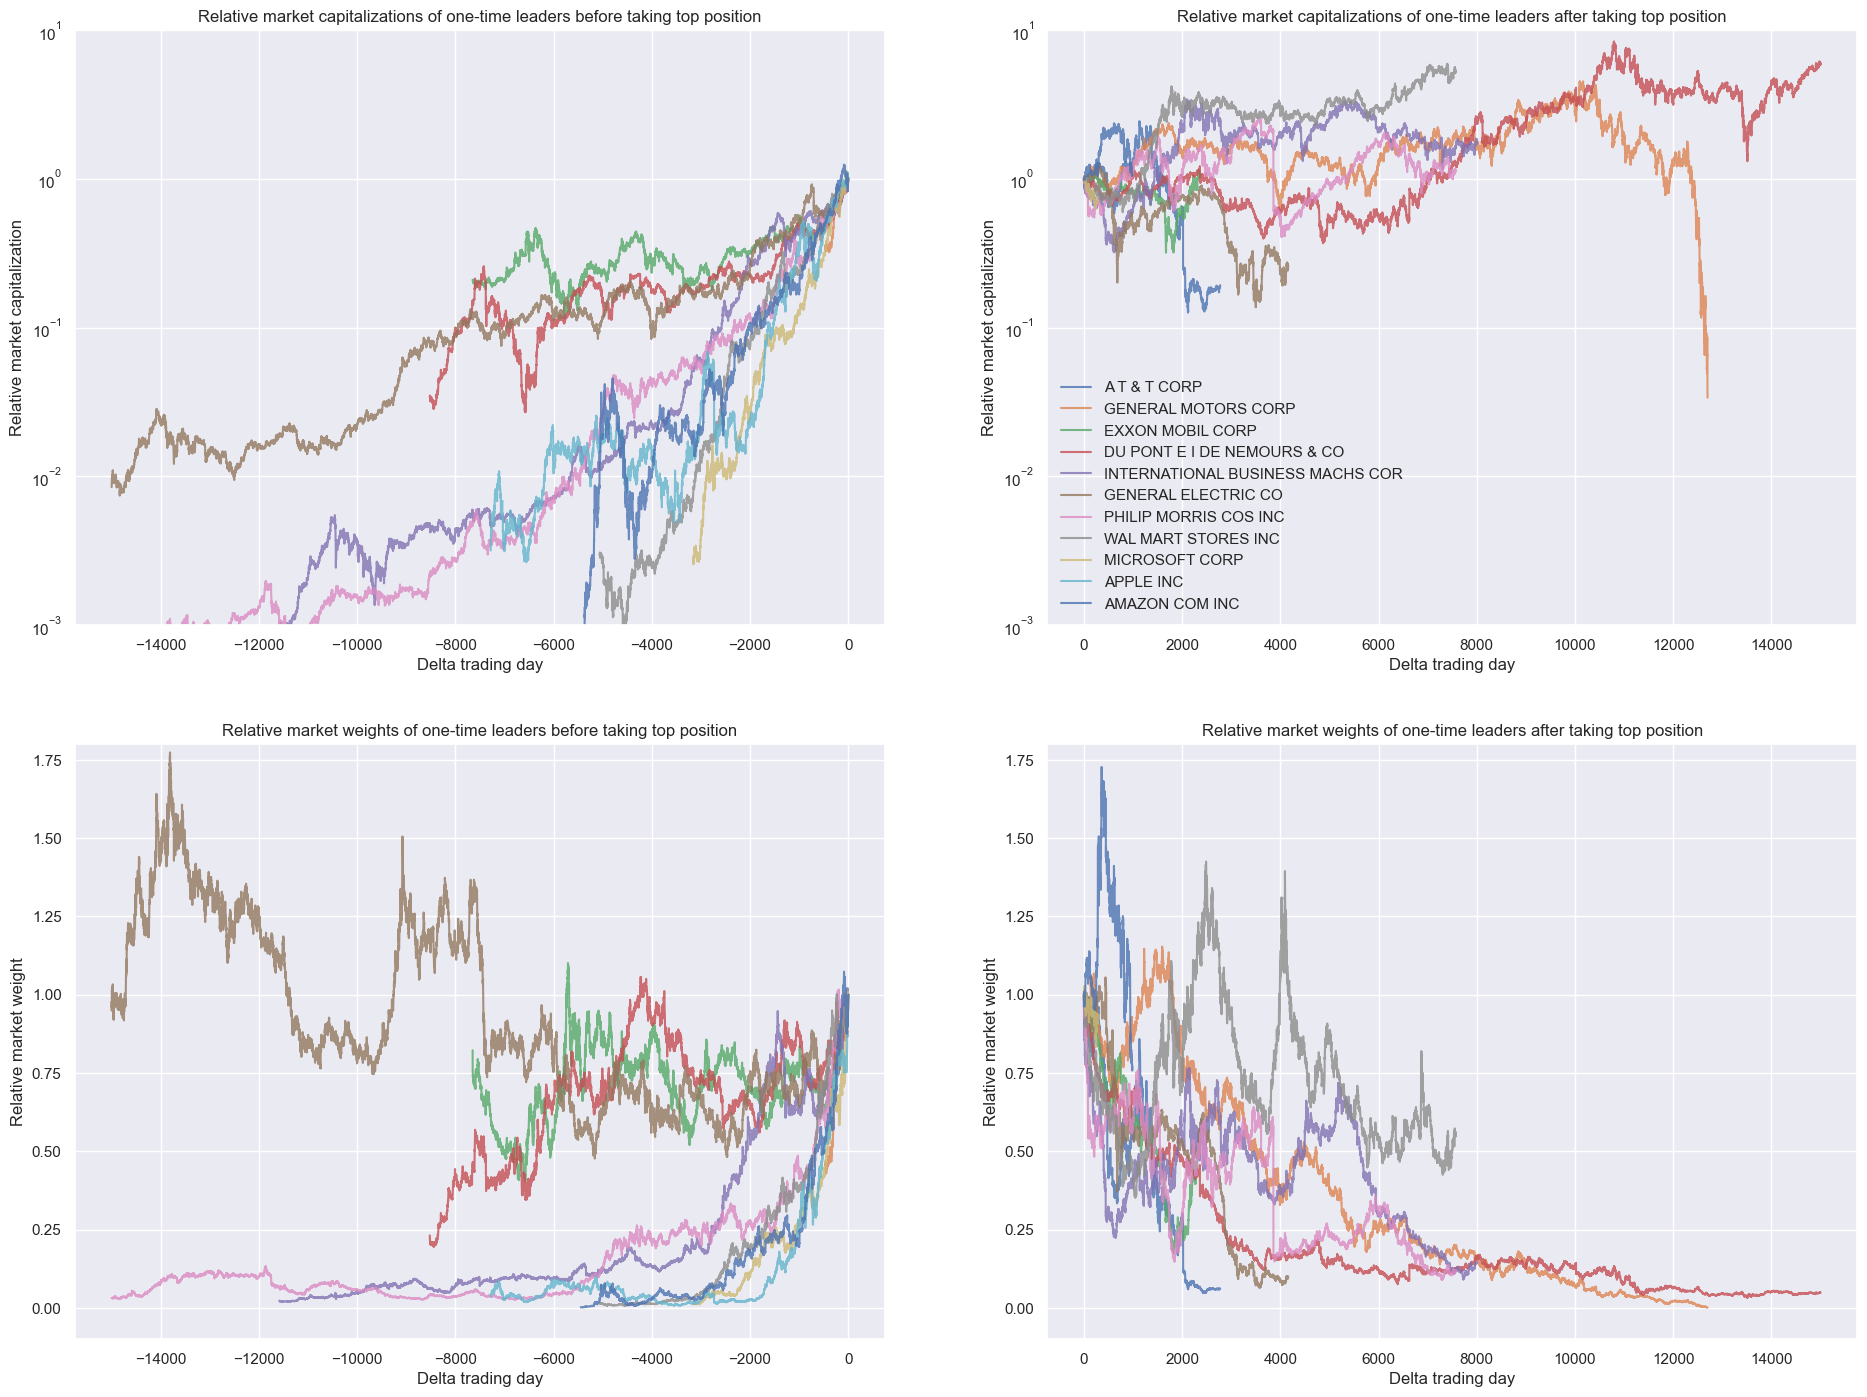

In [34]:
_, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(23,17))

df_caps_before[leaders.permno.unique()].plot(alpha=0.8, logy=True, ax=ax1, legend=None)
df_weights_before[leaders.permno.unique()].plot(alpha=0.8, ax=ax3, legend=None)

df_caps_after[leaders.permno.unique()].plot(alpha=0.8, logy=True, ax=ax2)
df_weights_after[leaders.permno.unique()].plot(alpha=0.8, ax=ax4, legend=None)

tmp = leaders.groupby(['permno'])['issuernm'].last()[leaders['permno'].unique()]
ax2.legend(tmp, frameon=False);

ax1.set_ylim(1/1000, 10)
ax2.set_ylim(1/1000, 10)
ax3.set_ylim(-0.1, 1.8)
ax4.set_ylim(-0.1, 1.8)

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Delta trading day')
for ax in (ax1, ax2):
    ax.set_ylabel('Relative market capitalization')
for ax in (ax3, ax4):
    ax.set_ylabel('Relative market weight')

ax1.set_title('Relative market capitalizations of one-time leaders before taking top position')
ax2.set_title('Relative market capitalizations of one-time leaders after taking top position')
ax3.set_title('Relative market weights of one-time leaders before taking top position')
ax4.set_title('Relative market weights of one-time leaders after taking top position');

The previous four panels show the evolution of the market leaders before (left) and after (right) taking the lead position. On the left hand side 0 corresponds to the first day, the companies take the lead position, on the right hand side, 0 corresponds to the last day (before December 2022) when the companies took the top position. Capitalizations and market weights are normalized to be one at time 0.

Instead of the market weight of the leader, we could also check the total market weight of, say, the top 1% of companies (`permno`s):

In [35]:
%%time

ranks = mktweights.rank(axis=1, ascending=False, method='first', pct=True)

CPU times: user 4min 40s, sys: 50.6 s, total: 5min 31s
Wall time: 6min 8s


In [36]:
pct = 0.01

In [37]:
%%time

top_x_pct = mktweights.mask(ranks.gt(pct)).sum(axis=1)

CPU times: user 33.3 s, sys: 34.7 s, total: 1min 8s
Wall time: 51 s


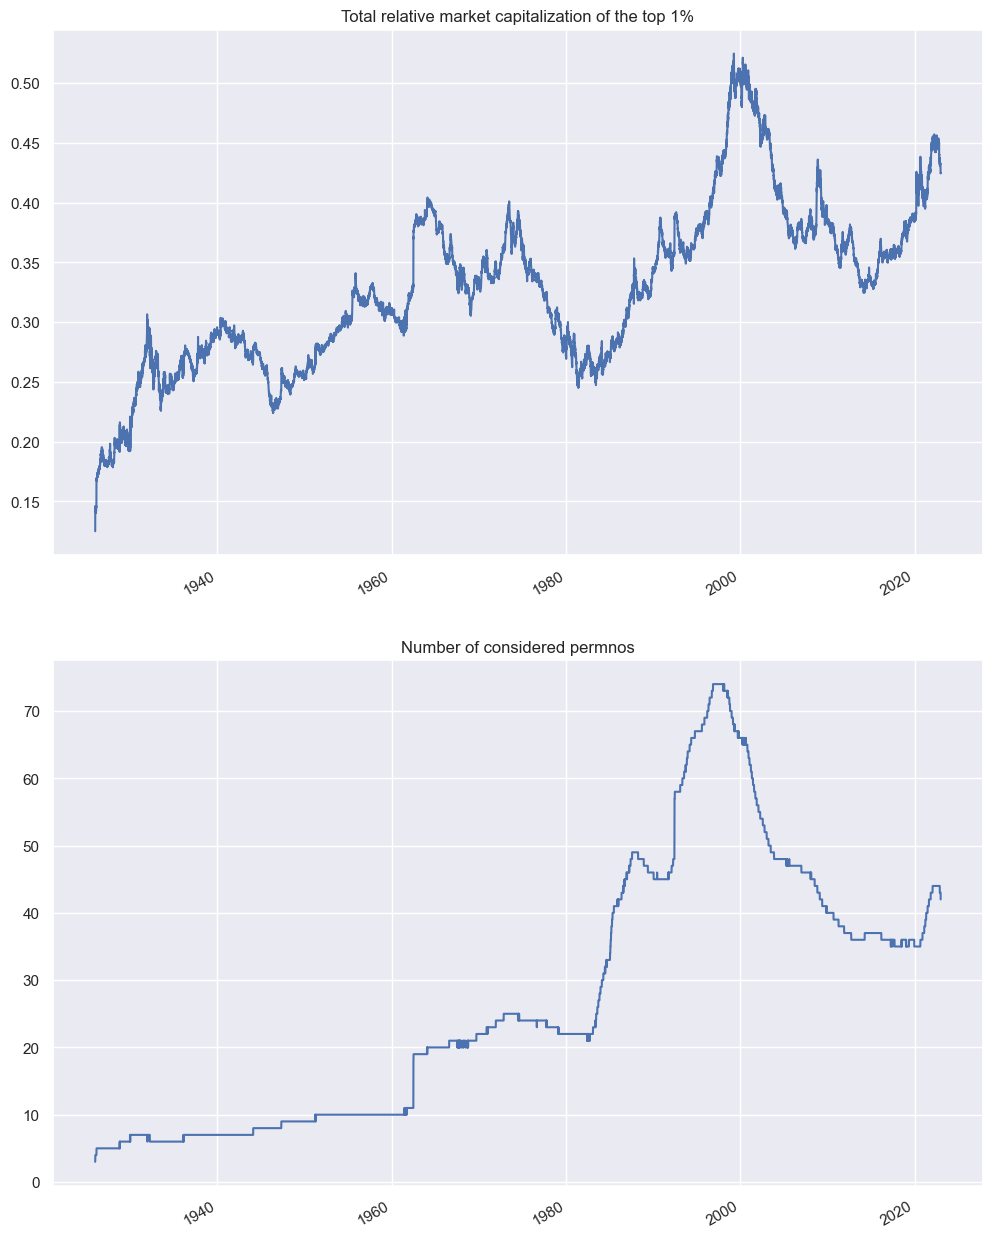

In [38]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,17))

top_x_pct.plot(ax=ax1)
ranks.le(pct).sum(axis=1).plot(ax=ax2)

ax1.set_title('Total relative market capitalization of the top {:.0f}%'.format(pct*100))
ax2.set_title('Number of considered permnos');

for ax in (ax1, ax2):
    ax.set_xlabel('')

### Measures of diversity

It suffices again to use monthly data here.

In [39]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly.h5') as store:
    mktcaps = store['df']['mthprevcap']

In [40]:
mktweights = mktcaps.div(mktcaps.sum(axis=1), axis=0)

In [41]:
ranks = mktweights.rank(axis=1, ascending=False, method='first')

In [42]:
n_top = 1000

In [43]:
mktweights_top = mktweights.mask(ranks.gt(n_top))[mktweights.count(axis=1).ge(n_top)]
mktweights_top = mktweights_top.div(mktweights_top.sum(axis=1), axis=0)

The measures of diversity implemented here are the following:

\begin{align*}
G(\mu) &= 1 - \sum_i \mu_i^2;\\
G(\mu) &=  - \sum_i \mu_i \log(\mu_i);\\
G(\mu) &= \left(\sum_i \mu_i^p\right)^{1/p}.
\end{align*}

In [44]:
# comment out to choose measure of diversity


G = lambda x: 1-(x**2).sum();           Gmax = lambda n: 1 - 1/n;     Gname = 'quadratic'
G = lambda x: (-x * np.log(x)).sum();   Gmax = lambda n: np.log(n);   Gname = 'entropic'

p = 0.8
#G = lambda x: (x**p).sum()**(1/p);      Gmax = lambda n: n**(1/p-1);  Gname = 'power'

In [45]:
df = mktweights.apply(G, axis=1).to_frame()
df.columns = ['G(μ) (all)']
df['Upper bound (all)'] = Gmax(mktweights.count(axis=1))

df['G(μ) (top {})'.format(n_top)] = mktweights_top.apply(G, axis=1)
df['Upper bound (top {})'.format(n_top)] = Gmax(n_top)
df['Upper bound (top {})'.format(n_top)] = df.iloc[:,3].mask(df.iloc[:,2].isnull())

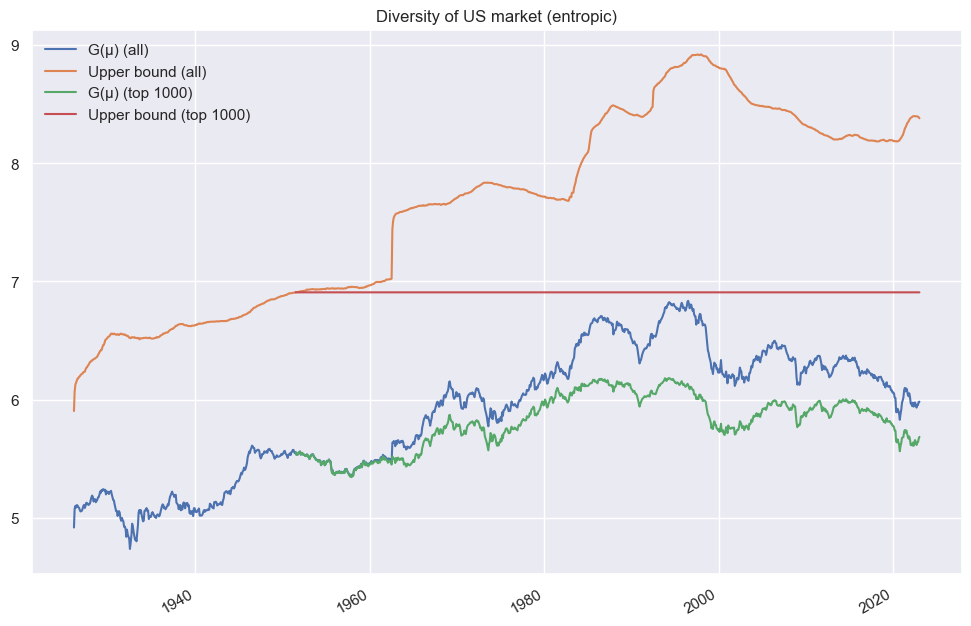

In [46]:
ax = df.plot(figsize=(12, 8), title='Diversity of US market ({})'.format(Gname))
ax.legend(frameon=False)
ax.set_xlabel('');